In [51]:
import numpy as np
from numpy import genfromtxt
from numpy import random
import matplotlib.gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy as sp
import sympy
from scipy.integrate import quad, dblquad, tplquad, simpson
from scipy import interpolate
#! /usr/bin/env python
# import lhapdf
from parton import mkPDF
import mcint
import vegas
import pandas as pd
from tqdm.notebook import tqdm
from scipy.optimize import minimize 

## My imports
from WIC_Pheno_Formulae import *

# Import LHE

In [52]:
## Import ##
MC_Events_LHE = []; temp_event = []; x = 0
file = open("MC_Events.lhe",'r').read().splitlines()
for line in file: 
    particle = line.strip().split()
    ### If we're at the 1st particle, increment x
    if particle[0] == 'PID1': x = x + 1
    ### If we encounter a particle (within the same event), append temp_event
    if len(particle) == 8 and x!=2:  
        temp_event.append(particle)
    ### If we encounter a particle in the next event, append MC_Events_LHE and reset temp_event, x
    if x==2:  
        MC_Events_LHE.append(temp_event)
        temp_event = []
        temp_event.append(particle)
        x = 1

## Convert to Floats ## 
MC_Events_LHE_new = [] 
for event in MC_Events_LHE: 
    temp_event = []
    for particle in event:
        new_particle = list(map(float, particle[1:]))
        temp_event.append( [particle[0]] + new_particle )
    MC_Events_LHE_new.append(temp_event)
MC_Events_LHE = MC_Events_LHE_new

In [53]:
def θ(X):
    x = X[0]; y = X[1]; z = X[2]
    return np.arctan(np.sqrt(x**2 + y**2)/z)
def η(θ):
    return -np.log(np.tan(θ/2))
def φ(X):
    x = X[0]; y = X[1]; z = X[2]
    if x>0          : return np.arctan(y/x)
    if x<0  and y>=0: return np.arctan(y/x) + np.pi
    if x<0  and y <0: return np.arctan(y/x) - np.pi
    if x==0 and y >0: return np.pi/2
    if x==0 and y <0: return -np.pi/2

# Loop for all kinematics

In [54]:
## Extract Kinematics from MC_Events_LHE
multiplicities = []; obs_mult = [];
electrons = []; muons = []; taus = [];
eNeutrinos = []; muNeutrinos = []; tauNeutrinos = []; Neutrinos = [];
jets = [];
μ1s   = []; μ2s   = []; μ3s   = []; μ4s   = []; μ5s  = []; 
μ1ps  = []; μ2ps  = []; μ3ps  = []; μ4ps  = []; μ5ps = []; 
v1s   = []; v2s   = []; v3s   = []; v4s   = []; v5s  = [];
v1ps  = []; v2ps  = []; v3ps  = []; v4ps  = []; v5ps = [];
Mff2  = []; Mff3  = []; Mff4  = []; Mff5  = [];
Mff2p = []; Mff3p = []; Mff4p = []; Mff5p = [];
θff2  = []; θff3  = []; θff4  = []; θff5  = [];
θffij = [];
ΔR = [];
MET = [];
# C = []; Thrust = []; Spherocity = []
Total_xMomentum = []; Total_yMomentum = []; Total_zMomentum = []; Total_Energy = [];
Total_InvMass = []; Total_InvMass_prime = []; fermion_energies = []; 
max1_fermion_energies = []; max2_fermion_energies = []; max3_fermion_energies = [];
max4_fermion_energies = []; max5_fermion_energies = []; max6_fermion_energies = [];
max7_fermion_energies = []; max8_fermion_energies = []; max9_fermion_energies = [];
max10_fermion_energies = []; max11_fermion_energies = []; max12_fermion_energies = [];
max13_fermion_energies = []; max14_fermion_energies = [];

for i, event in enumerate(MC_Events_LHE):
#     print(str(i) + ' of ' + str(len(MC_Events_LHE)))
    Px = 0; Py = 0; Pz = 0; E = 0;
    pxMET = []; pyMET = [];
    e_count = 0;   μ_count = 0;   τ_count = 0;
    νe_count = 0;  νμ_count = 0;   ντ_count = 0;
    jet_count = 0; 
    obs_mult_count = 0;
    momenta = []; momenta_mags = []; pi_dot_n = []; pi_x_n = [];
    fermion_momenta = []; quark_momenta = [];
    ######################## Multiplicities  ########################
    multiplicities.append(len(event))
    #################################################################
    for i, p in enumerate(event): 
        ######################## Mass & Velocity ########################
        if p[0] == 'PID1' :  
            μ1s.append(p[2])
            v1s.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID1p': 
            μ1ps.append(p[2])
            v1ps.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID2' :  
            μ2s.append(p[2])
            v2s.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID2p': 
            μ2ps.append(p[2])
            v2ps.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID3' : 
            μ3s.append(p[2])
            v3s.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID3p': 
            μ3ps.append(p[2])
            v3ps.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID4' : 
            μ4s.append(p[2])
            v4s.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID4p':
            μ4ps.append(p[2])
            v4ps.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID5' :  
            μ5s.append(p[2])
            v5s.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        if p[0] == 'PID5p':
            μ5ps.append(p[2])
            v5ps.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3])
        ###################################################################
        ##################### No. e's, mu's, jets, etc ####################
        if np.abs(p[1]) == 11: e_count += 1
        if np.abs(p[1]) == 13: μ_count += 1
        if np.abs(p[1]) == 15: τ_count += 1
        if np.abs(p[1]) == 12: νe_count += 1
        if np.abs(p[1]) == 14: νμ_count += 1
        if np.abs(p[1]) == 16: ντ_count += 1 
        if 1 <= np.abs(p[1]) <= 5: jet_count +=1
        ########## No. Observable Particles, Fermion Momenta & Energies ##########
        if p[1] != 1000000: 
            obs_mult_count += 1
            fermion_momenta.append([p[3],p[4],p[5],p[6]])
            fermion_energies.append(p[3])
        ##################### Ferimon Pair Inv Mass, Angles ########################
        if    p[0]=='PID2a' or p[0]=='PID3a' or p[0]=='PID4a' or p[0]=='PID5a'\
           or p[0]=='PID2ap' or p[0]=='PID3ap' or p[0]=='PID4ap' or p[0]=='PID5ap':
            fa=event[i][1:]; fb=event[i+1][1:]
            paDOTpb = fa[3]*fb[3] + fa[4]*fb[4] + fa[5]*fb[5]
            pa_mag = np.sqrt(fa[3]**2 + fa[4]**2 + fa[5]**2)
            pb_mag = np.sqrt(fb[3]**2 + fb[4]**2 + fb[5]**2)
        if p[0] == 'PID2a' :
            Mff2.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) )  
            θff2.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID3a' : 
            Mff3.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) ) 
            θff3.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID4a' :
            Mff4.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) ) 
            θff4.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID5a' :
            Mff5.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID2ap' :
            Mff2p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        if p[0] == 'PID3ap' : 
            Mff3p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) )
        if p[0] == 'PID4ap' : 
            Mff4p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        if p[0] == 'PID5ap' : 
            Mff5p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        ################################## MET ###########################################
        if p[1] == 1000000 and p[7] == 0:
            pxMET.append(p[4])
            pyMET.append(p[5])
        #################### Check Momentum & Energy Conservation ########################
        if p[7] == 0: 
            Px = Px + p[4]; Py = Py + p[5]; Pz = Pz + p[6]; E  = E  + p[3]
##############################################################################################################
##################### No. e's, mu's, jets, etc ###########################
    electrons.append(e_count)
    muons.append(μ_count)
    taus.append(τ_count)
    Neutrinos.append(νe_count + νμ_count + ντ_count)
#     muNeutrinos.append(νμ_count)
#     tauNeutrinos.append(ντ_count)
    jets.append(jet_count)
    obs_mult.append(obs_mult_count)
################################### MET ##################################
    MET.append(np.sqrt(sum(pxMET)**2 + sum(pyMET)**2))
######################### Max Fermion Energies ###########################
    if len(fermion_momenta) > 1:
        max1_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-1])
        max2_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-2])
    if len(fermion_momenta) > 2:
        max3_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-3])
    if len(fermion_momenta) > 3:
        max4_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-4])
    if len(fermion_momenta) > 4:
        max5_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-5])
    if len(fermion_momenta) > 5:
        max6_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-6])
    if len(fermion_momenta) > 6:
        max7_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-7])
    if len(fermion_momenta) > 7:
        max8_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-8])
    if len(fermion_momenta) > 8:
        max9_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-9])
    if len(fermion_momenta) > 9:
        max10_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-10])
    if len(fermion_momenta) > 10:
        max11_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-11])
    if len(fermion_momenta) > 11:
        max12_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-12])
    if len(fermion_momenta) > 12:
        max13_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-13])
    if len(fermion_momenta) > 13:
        max14_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-14])
##################### Angles Between Fermion Pairs #######################
    for m, fp1 in enumerate(fermion_momenta):
        for n, fp2 in enumerate(fermion_momenta):
            if m > n: 
                θffij.append((fp1[1]*fp2[1] + fp1[2]*fp2[2] + fp1[3]*fp2[3]) /\
                             (np.sqrt(fp1[1]**2 + fp1[2]**2 + fp1[3]**2)*\
                              np.sqrt(fp2[1]**2 + fp2[2]**2 + fp2[3]**2)))
############################ ΔR of quarks ################################
    for m, qp1 in enumerate(quark_momenta):
        for n, qp2 in enumerate(quark_momenta):
            if m < n: 
                ΔR.append(np.sqrt( (η(θ(qp1)) - η(θ(qp2)))**2 + (φ(qp1) - φ(qp2))**2) )
##################### Momentum Conservation check ########################
    Total_xMomentum.append(Px)
    Total_yMomentum.append(Py)
    Total_zMomentum.append(Pz)
    Total_Energy.append(E)
    ########################  Inv Mass of Entire Event  ######################## 
    Es = []; pxs = []; pys = []; pzs = []
    Eps = []; ppxs = []; ppys = []; ppzs = []
    p = 0
    while True:
        particle = event[p]
        if particle[0] == 'PID1p': break
        p = p + 1
        if particle[7] == 0: 
            Es.append(particle[3])
            pxs.append(particle[4])
            pys.append(particle[5])
            pzs.append(particle[6])
    Total_InvMass.append(np.sqrt(sum(Es)**2 - sum(pxs)**2 - sum(pys)**2 - sum(pzs)**2))
    for k in range(p, len(event)):
        if event[k][7] == 0:
            Eps.append(event[k][3])
            ppxs.append(event[k][4])
            ppys.append(event[k][5])
            ppzs.append(event[k][6])
    Total_InvMass_prime.append(np.sqrt(sum(Eps)**2 - sum(ppxs)**2 - sum(ppys)**2 - sum(ppzs)**2))
    ################################################################################################
print(Total_xMomentum[:10])
print(Total_yMomentum[:10])
print(Total_zMomentum[:10])
print(Total_Energy[:10])

/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_43643/2905072860.py:5: RuntimeWarning: invalid value encountered in log
  return -np.log(np.tan(θ/2))
/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_43643/2905072860.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.arctan(np.sqrt(x**2 + y**2)/z)


[0.00010000000000331966, 1.7763568394002505e-15, 2.842170943040401e-14, 1.4210854715202004e-14, 0.0, 3.552713678800501e-15, 0.0, 0.0, 0.0, 7.105427357601002e-15]
[-3.552713678800501e-15, 7.105427357601002e-15, 9.99999999891088e-05, 2.842170943040401e-14, 0.0, -0.00019999999999975593, 9.99999999891088e-05, 0.0, 0.0, -0.00010000000000331966]
[-0.00010000000000331966, 0.0, -9.999999999266151e-05, -0.00010000000000331966, 0.0, -0.00010000000000331966, 1.4210854715202004e-14, 9.99999999891088e-05, -0.00010000000000331966, 3.552713678800501e-15]
[500.0, 500.0, 500.0001, 500.0001, 500.0, 500.0, 500.0, 499.99989999999997, 499.99999999999994, 499.9999]


# Loop for C-parameter, Thrust, Spherocity
(takes a while to run ... )

In [89]:
C = []; Thrust = []; Spherocity = []
for i, event in enumerate(MC_Events_LHE):
#     if i%10!=0:
#         continue
#     else: 
    if i%5000==0: print(str(i) + ' of ' + str(len(MC_Events_LHE)))
    #################################################################################
    momenta = []; momenta_mags = []; pi_dot_n = []; pi_x_n = [];
    ###################### C-Parameter, Thrust, Spherocity ###########################
    for i, p in enumerate(event): 
        if p[7] == 0:
            momenta.append([p[4], p[5], p[6]])
            momenta_mags.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2))
            angles = 'placeholder'
            def n(θ,φ): return [np.sin(θ)*np.cos(φ),np.sin(θ)*np.sin(φ),np.cos(θ)] 
            def p_dot_n_func(angles,p): 
                return lambda angles: np.abs(np.dot([p[4], p[5], p[6]], n(angles[0],angles[1])))
            def p_x_n_func(angles,p):
                return lambda angles: np.sqrt(np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[0]**2 +\
                                              np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[1]**2 +\
                                              np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[2]**2)
            pi_dot_n.append(p_dot_n_func(angles,p))
            pi_x_n.append(p_x_n_func(angles,p))
    ###################################################################################     
    c1 = np.outer(momenta_mags, momenta_mags)
    c2 = np.matmul(momenta, np.array(momenta).transpose())
    C.append( (3/2)*np.sum(c1 - (c2**2)/c1)/(np.sum(momenta_mags)**2) )
    max_index = momenta_mags.index(max(momenta_mags))
    max_momenta = momenta[max_index]
    θ_guess = θ(max_momenta)
    φ_guess = φ(max_momenta)
#     print(θ(max_momenta), φ(max_momenta))
#     θ_guess = np.pi/2; φ_guess = np.pi
    pi_d ot_n = np.array(pi_dot_n)
    def sum_pi_dot_n(angles):
        return -np.sum(np.array([pni(angles) for pni in pi_dot_n]))/np.sum(momenta_mags)
    def sum_pi_x_n(angles):
        return ((4/np.pi)*(np.sum(np.array([pni(angles) for pni in pi_x_n]))/np.sum(momenta_mags)))**2
    b = ((0,np.pi),(0,2*np.pi))
    max_sum_pi_dot_n = minimize(sum_pi_dot_n, (θ_guess,φ_guess),
                                 method='COBYLA', bounds=b)
    min_sum_pi_x_n = minimize(sum_pi_x_n, (θ_guess,φ_guess),
                                 method='COBYLA', bounds=b)
#     print(max_sum_pi_dot_n.x, min_sum_pi_x_n.x)
    Thrust.append(-max_sum_pi_dot_n.fun)
    Spherocity.append(min_sum_pi_x_n.fun)

0 of 23732
5000 of 23732
10000 of 23732
15000 of 23732
20000 of 23732


# C-Parameter, Thrust, Spherocity

Text(0.5, 0, 'C-Parameter')

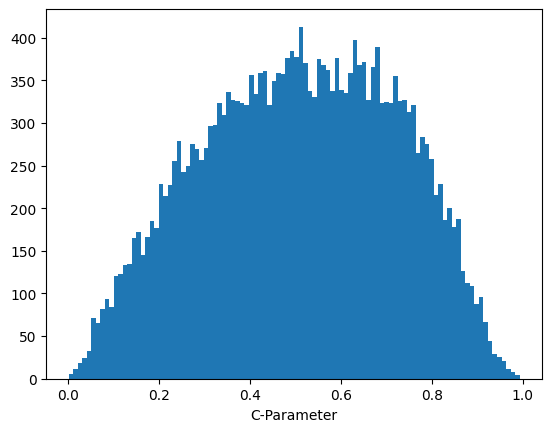

In [90]:
plt.hist(C,bins=100);
plt.xlabel("C-Parameter")

0.5170414456237489 0.999833614301078


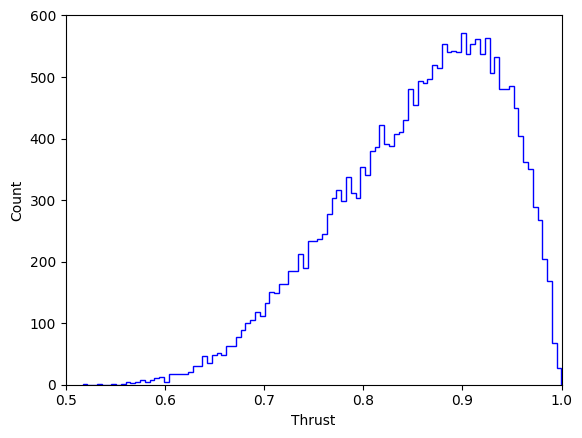

In [91]:
plt.hist(Thrust,bins=100,histtype='step',color='b');
plt.xlabel('Thrust')
plt.ylabel('Count')
print(min(Thrust), max(Thrust))
plt.xlim(0.5,1);
plt.savefig('VegasMC_WIC_Thrust.png')
# plt.yscale('log')

2.5872461322966876e-05 0.9258128384080597


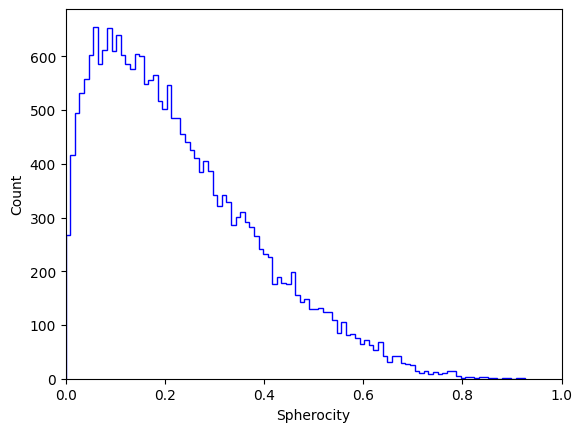

In [92]:
plt.hist(Spherocity,bins=100,histtype='step',color='b');
plt.xlim(0,1);
plt.ylabel('Count')
print(min(Spherocity), max(Spherocity))
plt.xlabel("Spherocity");
plt.savefig('VegasMC_WIC_Spherocity.png')

# Kinematics

23732 23694 21582 10797 1735
23732 23681 21511 10708 1717


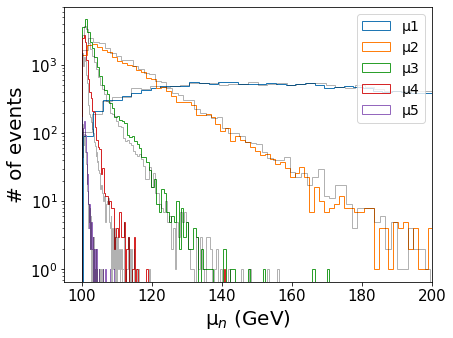

In [55]:
plt.figure(figsize=(6.4, 4.8))
plt.hist(μ1s, bins=100, histtype='step');
plt.hist(μ2s, bins=100, histtype='step');
plt.hist(μ3s, bins=100, histtype='step');
plt.hist(μ4s, bins=100, histtype='step');
plt.hist(μ5s, bins=100, histtype='step');
plt.xlim(95,200)
print(len(μ1s), len(μ2s), len(μ3s), len(μ4s), len(μ5s))
print(len(μ1ps), len(μ2ps), len(μ3ps), len(μ4ps), len(μ5ps))
plt.hist(μ1ps, bins=100, histtype='step', color='k', alpha=0.3);
plt.hist(μ2ps, bins=100, histtype='step', color='k', alpha=0.3);
plt.hist(μ3ps, bins=100, histtype='step', color='k', alpha=0.3);
plt.hist(μ4ps, bins=100, histtype='step', color='k', alpha=0.3);
plt.hist(μ5ps, bins=100, histtype='step', color='k', alpha=0.3);
plt.legend(['μ1', 'μ2','μ3', 'μ4','μ5'], fontsize=14, loc="upper right");
plt.yscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('μ$_{n}$ (GeV)', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()
plt.savefig('VegasMC_WIC_MassDistributions.png')

23732 23694 21582 10797 1735
23732 23681 21511 10708 1717


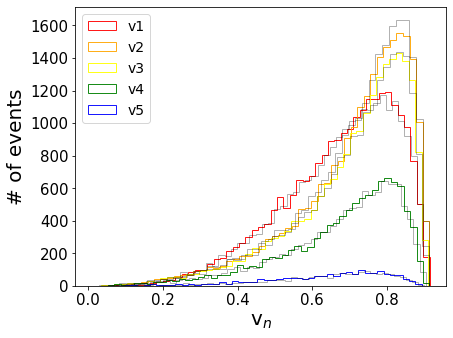

In [56]:
plt.figure(figsize=(6.4, 4.8))
plt.hist(v1s, bins=50, histtype='step', color='red', alpha=0.9);
plt.hist(v2s, bins=50, histtype='step', color='orange', alpha=0.9);
plt.hist(v3s, bins=50, histtype='step', color='yellow', alpha=0.9);
plt.hist(v4s, bins=50, histtype='step', color='green', alpha=0.9);
plt.hist(v5s, bins=50, histtype='step', color='blue', alpha=0.9);
# plt.xlim(95,150)
print(len(v1s), len(v2s), len(v3s), len(v4s), len(v5s))
print(len(v1ps), len(v2ps), len(v3ps), len(v4ps), len(v5ps))
plt.hist(v1ps, bins=50, histtype='step', color='k', alpha=0.3);
plt.hist(v2ps, bins=50, histtype='step', color='k', alpha=0.3);
plt.hist(v3ps, bins=50, histtype='step', color='k', alpha=0.3);
plt.hist(v4ps, bins=50, histtype='step', color='k', alpha=0.3);
plt.hist(v5ps, bins=50, histtype='step', color='k', alpha=0.3);
plt.legend(['v1', 'v2', 'v3', 'v4', 'v5'], fontsize=14, loc="upper left");
plt.ylabel('# of events',size=20)
plt.xlabel('v$_{n}$', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()
plt.savefig('VegasMC_WIC_VelocityDistributions.png')
# plt.yscale('log')

23694 21582 10797 1735
23681 21511 10708 1717


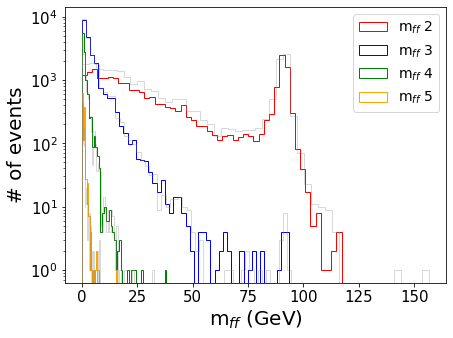

In [57]:
plt.figure(figsize=(6.4, 4.8))
print(len(Mff2), len(Mff3), len(Mff4), len(Mff5))
print(len(Mff2p), len(Mff3p), len(Mff4p), len(Mff5p))
plt.hist(Mff2, bins=50, histtype='step', color='red', alpha=1);
plt.hist(Mff3, bins=50, histtype='step', color='blue', alpha=1);
plt.hist(Mff4, bins=50, histtype='step', color='green', alpha=1);
plt.hist(Mff5, bins=50, histtype='step', color='orange', alpha=1);
plt.hist(Mff2p, bins=50, histtype='step', color='gray', alpha=0.3);
plt.hist(Mff3p, bins=50, histtype='step', color='gray', alpha=0.3);
plt.hist(Mff4p, bins=50, histtype='step', color='gray', alpha=0.3);
plt.hist(Mff5p, bins=50, histtype='step', color='gray', alpha=0.3);
plt.legend(['m$_{ff}$ 2', 'm$_{ff}$ 3', 'm$_{ff}$ 4', 'm$_{ff}$ 5'], fontsize=14, loc="upper right");
plt.yscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('m$_{ff}$ (GeV)', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()
plt.savefig('VegasMC_WIC_MffDistributions.png')

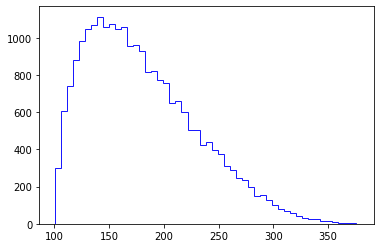

In [58]:
plt.hist(Total_InvMass, bins=50, histtype='step', color='blue', alpha=0.9);
plt.hist(Total_InvMass_prime, bins=50, histtype='step', color='gray', alpha=0.);

23732
23732
23727
23727
23522
23522
21644
21644
15115
15115


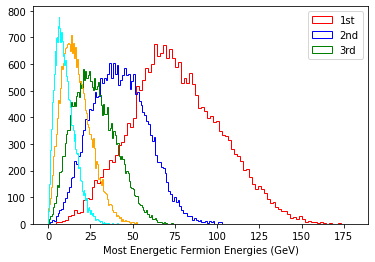

In [59]:
plt.hist(max1_fermion_energies, bins=100, histtype='step', color='red');
plt.hist(max2_fermion_energies, bins=100, histtype='step', color='blue');
plt.hist(max3_fermion_energies, bins=100, histtype='step', color='green');
plt.hist(max4_fermion_energies, bins=100, histtype='step', color='orange');
plt.hist(max5_fermion_energies, bins=100, histtype='step', color='cyan');
print(len(max1_fermion_energies))
print(len(max2_fermion_energies))
print(len(max3_fermion_energies))
print(len(max4_fermion_energies))
print(len(max5_fermion_energies))
print(len(max6_fermion_energies))
print(len(max7_fermion_energies))
print(len(max8_fermion_energies))
print(len(max9_fermion_energies))
print(len(max10_fermion_energies))
plt.xlabel('Most Energetic Fermion Energies (GeV)')
plt.legend(['1st', '2nd', '3rd'])
plt.savefig('VegasMC_WIC_FermionEnergies.png')

(0.0, 20.0)

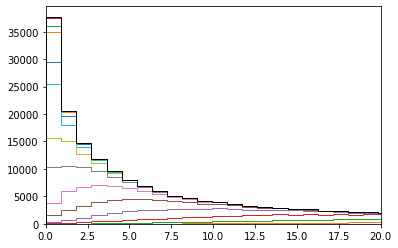

In [61]:
plt.hist([max1_fermion_energies, max2_fermion_energies, 
          max3_fermion_energies, max4_fermion_energies, 
          max5_fermion_energies, max6_fermion_energies, 
          max7_fermion_energies, max8_fermion_energies,
          max9_fermion_energies, max10_fermion_energies,
          max11_fermion_energies, max12_fermion_energies,
          max13_fermion_energies, max14_fermion_energies], bins=200, histtype='step', stacked=True);
# plt.yscale('log')
plt.hist(fermion_energies, bins=200, histtype='step', color='k')
plt.xlim(0,20)

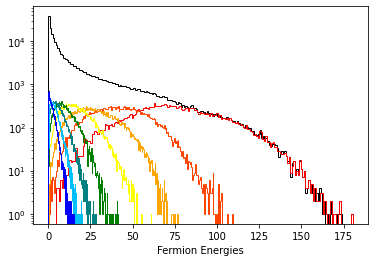

In [62]:
plt.hist(fermion_energies, bins=200, histtype='step', color='black');
plt.hist(max1_fermion_energies, bins=200, histtype='step', color='red');
plt.hist(max2_fermion_energies, bins=200, histtype='step', color='orangered');
plt.hist(max3_fermion_energies, bins=200, histtype='step', color='orange');
plt.hist(max4_fermion_energies, bins=200, histtype='step', color='yellow');
plt.hist(max5_fermion_energies, bins=200, histtype='step', color='green');
plt.hist(max6_fermion_energies, bins=200, histtype='step', color='teal');
plt.hist(max7_fermion_energies, bins=200, histtype='step', color='deepskyblue');
plt.hist(max8_fermion_energies, bins=200, histtype='step', color='blue');
# plt.hist(max9_fermion_energies, bins=200, histtype='step', color='magenta');
# plt.hist(max10_fermion_energies, bins=200, histtype='step', color='indigo');
# plt.hist(max11_fermion_energies, bins=200, histtype='step', color='gray');
plt.xlabel('Fermion Energies')
plt.yscale('log')
# plt.xscale('log')

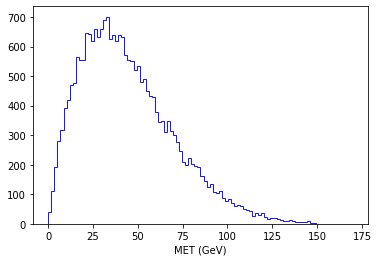

In [63]:
plt.hist(MET, bins=100, histtype='step', color='blue', alpha=0.9);
plt.xlabel('MET (GeV)')
plt.savefig('VegasMC_WIC_MET.png')

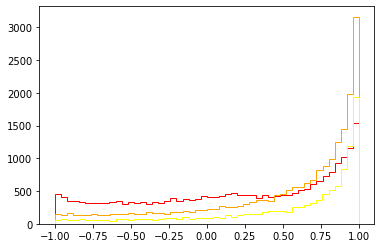

In [64]:
# Angle between fermion pairs
plt.hist(θff2, bins=50, histtype='step', color='red',density=False);
plt.hist(θff3, bins=50, histtype='step', color='orange',density=False);
plt.hist(θff4, bins=50, histtype='step', color='yellow',density=False);

Text(0.5, 0, 'θ$_{ij}$')

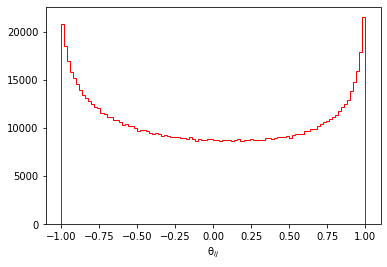

In [65]:
# Angles between all fermion pairs in each event
plt.hist(θffij, bins=100, histtype='step', color='red',density=False);
plt.xlabel('θ$_{ij}$')

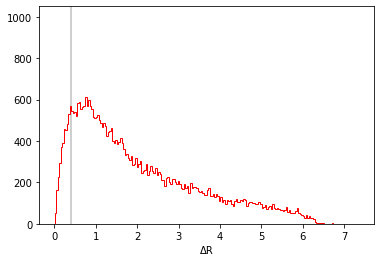

In [66]:
# Delta R
plt.hist(ΔR, bins=200, histtype='step', color='red',density=False);
plt.scatter(0.4,1000,marker='|',s=500000, color='gray',alpha=0.5)
plt.xlabel('ΔR')
# plt.yscale('log')
plt.savefig('VegasMC_WIC_DeltaR.png')

# Multiplicities

29
5


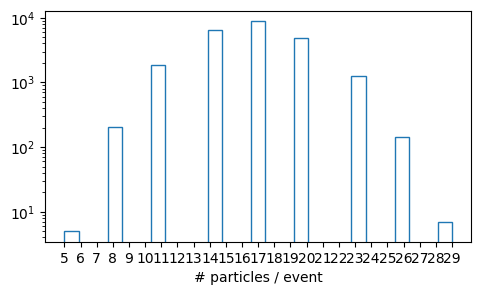

In [68]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(1, 1, figsize = (5.5,3))

print(max(multiplicities))
print(min(multiplicities))
plt.hist(multiplicities, bins=27, histtype='step');
plt.xlabel('# particles / event');
# plt.xlim(0,28)

## ticks
import math
new_list = range(math.floor(min(multiplicities)), math.ceil(max(multiplicities))+1)
plt.xticks(new_list);
plt.yscale('log')

[19796  3645   281    10]
[19784  3637   298    13]
[19756  3721   248     7]


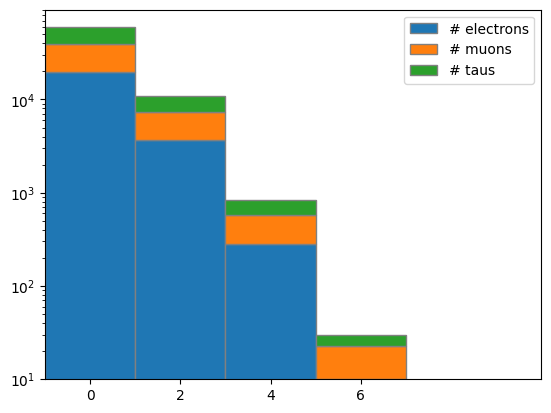

In [86]:
## Electron, Muon, & Tau multiplicities
## (have to adjust 'counts' array if they're not the same length)
labels, e_counts = np.unique(electrons, return_counts=True)
labels, mu_counts = np.unique(muons, return_counts=True)
labels, tau_counts = np.unique(taus, return_counts=True)

print(e_counts)
print(mu_counts)
print(tau_counts)

fig, ax = plt.subplots()
ax.bar(labels, e_counts, align='center', width=2, edgecolor='gray');
ax.bar(labels, mu_counts, align='center', width=2, edgecolor='gray', bottom=e_counts);
ax.bar(labels, tau_counts, align='center', width=2, edgecolor='gray', bottom=mu_counts+e_counts);

plt.gca().set_xticks(labels);
# (ns, bins, patches) = plt.hist([electrons, muons, taus], bins=4, 
#                                histtype='bar',stacked=True, edgecolor='gray');
ax.legend(['# electrons', '# muons', '# taus'])
plt.xlim(-1,10)
# plt.xticks([0,2,4,6])
plt.yscale('log')

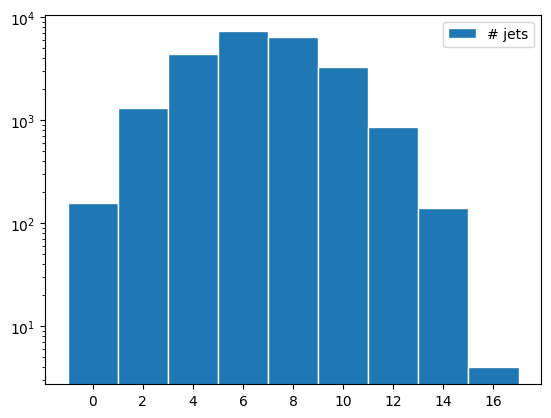

In [83]:
labels, counts = np.unique(jets, return_counts=True)
plt.bar(labels, counts, align='center', width=2, edgecolor='white');
plt.gca().set_xticks(labels);
plt.legend(['# jets'])
# (ns, bins, patches) = plt.hist(np.array(jets), histtype='bar', 
#                                bins=9, rwidth=1, edgecolor='gray');
# plt.xticks([0,2,4,6,8,10,12,14,16])
plt.yscale('log')

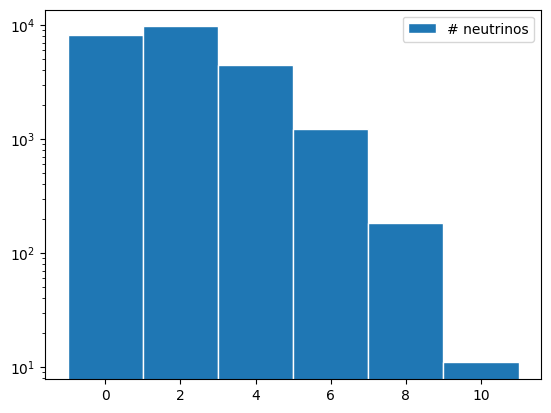

In [84]:
labels, nu_counts = np.unique(Neutrinos, return_counts=True)
plt.bar(labels, nu_counts, align='center', width=2, edgecolor='white');
plt.gca().set_xticks(labels);
plt.legend(['# neutrinos'])
plt.yscale('log')

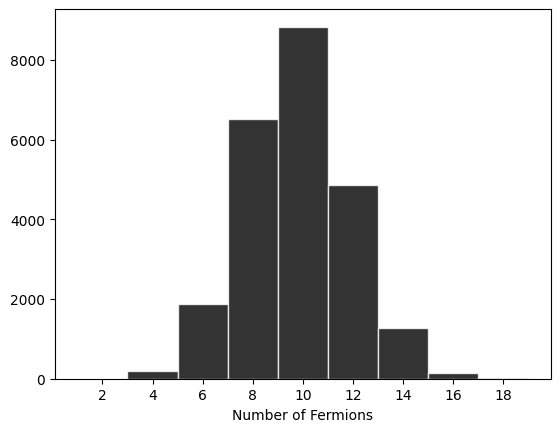

In [85]:
labels, obs_counts = np.unique(obs_mult, return_counts=True)
plt.bar(labels, obs_counts, align='center', width=2, edgecolor='white',color='k',alpha=0.8);
plt.gca().set_xticks(labels);
plt.xlabel('Number of Fermions')
# plt.legend(['# Fermions'])
plt.savefig('VegasMC_WIC_FermionMult.png')
# plt.yscale('log')